In [1]:
%matplotlib inline
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import *
import torchvision

In [2]:
training_data_set = torchvision.datasets.MNIST('./dataset/mnist/training.pt', train=True, download=True)
test_data_set = torchvision.datasets.MNIST('./dataset/mnist/test.pt', train=False, download=True)

Number of samples in the training set: 60000
Number of samples in the test set: 10000
<PIL.Image.Image image mode=L size=28x28 at 0x1A85CBAE860> -> tensor(5)


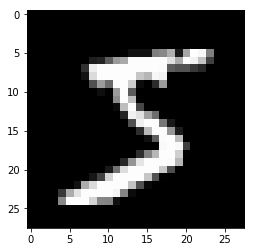

In [3]:
"""
Observing some of the data
"""
print("Number of samples in the training set:", len(training_data_set))
print("Number of samples in the test set:", len(test_data_set))
image, target = training_data_set[0]
print(image, "->", target)
plt.imshow(image)

In [4]:
"""
How to transform the data into vectors
"""
pipeline = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.2, 0.2, 0.2])
])
xs = pipeline(image)
xs.shape

torch.Size([1, 28, 28])

In [5]:
"""
Working with data loader for images
"""

# You need to transform the data to vectors to put it inside a data loader
training_data_set.transform = pipeline
test_data_set.transform = pipeline

data_loader = DataLoader(training_data_set, batch_size=2, shuffle=True)
for images, targets in data_loader:
    print(images)
    print(targets)
    break

tensor([[[[-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          ...,
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000]]],


        [[[-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          ...,
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000]]]])
tensor([1, 8])


[Epoch 0] Training loss: 267.26322488486767
[Epoch 0] Accuracy: 54593/60000 (90.99%)
[Epoch 1] Training loss: 196.67112884670496
[Epoch 1] Accuracy: 54777/60000 (91.30%)
[Epoch 2] Training loss: 191.80606784671545
[Epoch 2] Accuracy: 54679/60000 (91.13%)
[Epoch 3] Training loss: 187.64222344011068
[Epoch 3] Accuracy: 55380/60000 (92.30%)
[Epoch 4] Training loss: 183.88519762456417
[Epoch 4] Accuracy: 55257/60000 (92.09%)


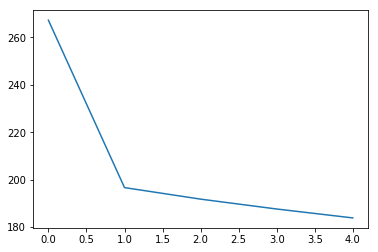

In [6]:
"""
Training a basic Linear classifier for images
"""

class LinearClassifier(nn.Module):
    def __init__(self, width=28, height=28):
        super().__init__()
        self.fc = nn.Linear(width * height, 10)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, xs, with_softmax=True):
        batch_size, channels, width, height = xs.shape
        xs = xs.reshape((batch_size, -1))
        xs = self.fc(xs)
        if with_softmax:
            xs = self.softmax(xs)
        return xs

def train(model, training_data_set, test_data_set, epoch_count=10):
    training_data_set.transform = pipeline
    test_data_set.transform = pipeline  
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    training_data_loader = DataLoader(training_data_set, batch_size=100, shuffle=True)
    test_data_loader = DataLoader(training_data_set, batch_size=100, shuffle=True)

    losses = []

    for epoch in range(epoch_count):
        cumulative_loss = 0.
        model.train()
        for images, targets in training_data_loader:
            optimizer.zero_grad()
            got = model(images, with_softmax=False)
            loss = criterion(got, targets)
            cumulative_loss += loss.item()
            loss.backward()
            optimizer.step()

        print("[Epoch {0}] Training loss: {1}".format(epoch, cumulative_loss))
        losses.append(cumulative_loss)

        correct = 0
        total = 0
        model.eval()
        for images, targets in test_data_loader:
            got = model(images, with_softmax=True)
            predicted = torch.argmax(got, dim=-1)
            predicted = predicted.view(-1)
            targets = targets.view(-1)
            correct += (predicted == targets).sum().item()
            total += len(targets)

        print("[Epoch {0}] Accuracy: {1}/{2} ({3:.2f}%)".format(epoch, correct, total, 100 * correct/total))

    plt.plot(losses)
    plt.show()
    
linear_model = LinearClassifier()
train(linear_model, training_data_set, test_data_set, epoch_count=5)

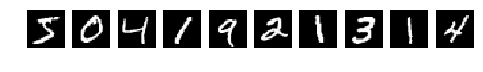

[5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [7]:
"""
Trying the model
"""

def predict(model, data_set, image_indexes):
    fig, ax = plt.subplots(figsize=(8, 8), ncols=len(image_indexes))
    predicted = []
    training_data_set.transform = None
    for image_idx in image_indexes:
        image, target = data_set[image_idx]
        xs = pipeline(image)
        xs = xs.unsqueeze(dim=0)
        ys = model(xs, with_softmax=True)
        predicted.append(torch.argmax(ys, dim=-1).item())
        ax[image_idx].imshow(image)
        ax[image_idx].set_axis_off()
    plt.show()
    print(predicted)

predict(linear_model, training_data_set, range(10))

[Epoch 0] Training loss: 262.67323441803455
[Epoch 0] Accuracy: 54926/60000 (91.54%)
[Epoch 1] Training loss: 152.94081577658653
[Epoch 1] Accuracy: 56400/60000 (94.00%)
[Epoch 2] Training loss: 120.93054033815861
[Epoch 2] Accuracy: 56985/60000 (94.97%)
[Epoch 3] Training loss: 102.58904355019331
[Epoch 3] Accuracy: 57389/60000 (95.65%)
[Epoch 4] Training loss: 91.69354344904423
[Epoch 4] Accuracy: 57473/60000 (95.79%)


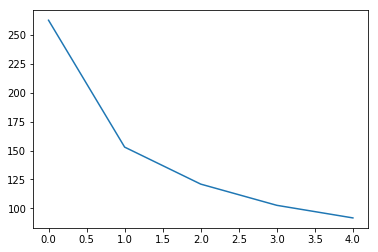

In [8]:
class TwoLayerClassifier(nn.Module):
    def __init__(self, width=28, height=28):
        super().__init__()
        self.fc = nn.Sequential(nn.Linear(width * height, 50), nn.ReLU(), nn.Linear(50, 10))
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, xs, with_softmax=True):
        batch_size, channels, width, height = xs.shape
        xs = xs.reshape((batch_size, -1))
        xs = self.fc(xs)
        if with_softmax:
            xs = self.softmax(xs)
        return xs

two_layer_model = TwoLayerClassifier()
train(two_layer_model, training_data_set, test_data_set, epoch_count=5)

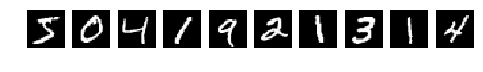

[5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [9]:
predict(two_layer_model, training_data_set, range(10))

[Epoch 0] Training loss: 134.61638176627457
[Epoch 0] Accuracy: 58294/60000 (97.16%)
[Epoch 1] Training loss: 51.07596118096262
[Epoch 1] Accuracy: 58728/60000 (97.88%)
[Epoch 2] Training loss: 40.16010213177651
[Epoch 2] Accuracy: 59099/60000 (98.50%)
[Epoch 3] Training loss: 34.483002638444304
[Epoch 3] Accuracy: 59178/60000 (98.63%)
[Epoch 4] Training loss: 29.569490973837674
[Epoch 4] Accuracy: 59083/60000 (98.47%)


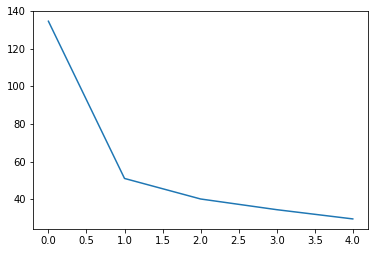

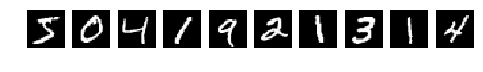

[5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [19]:
# Always create your models by creating a vector representing several samples
# test_entries = torch.zeros(3, 1, 28, 28)

class ConvolutionalClassifier(nn.Module):
    def __init__(self, width=28, height=28):
        super().__init__()
        self.conv = nn.Sequential(
                    nn.Conv2d(in_channels=1,   # Just one color channel here
                              out_channels=10, # How many channels do you want as output
                              kernel_size=5,   # Size of the convolutional layer
                              stride=1,        # Size of the step
                              padding=0),
                    nn.MaxPool2d(kernel_size=2),
                    nn.ReLU())
        self.fc = nn.Linear(self.convolution_output_length(width, height), 10)
        self.softmax = nn.Softmax(dim=-1)
    
    def convolution_output_shape(self, width, height):
        xs = self.conv(torch.zeros(1, 1, width, height)) # One sample, with one channel, of size 28 times 28
        return xs.shape
    
    def convolution_output_length(self, width, height):
        # Never hardcode that kind of stuff, compute it!
        length = 1
        for d in self.convolution_output_shape(width, height):
            length *= d
        return length
    
    def forward(self, xs, with_softmax=True):
        batch_size, channels, width, height = xs.shape
        xs = self.conv(xs)
        xs = xs.reshape((batch_size, -1))
        xs = self.fc(xs)
        if with_softmax:
            xs = self.softmax(xs)
        return xs

convolutional_model = ConvolutionalClassifier()
train(convolutional_model, training_data_set, test_data_set, epoch_count=5)
predict(convolutional_model, training_data_set, range(10))

In [11]:
# TODO - now the hard part is to:
# 1. create a data set in which the images are bigger, and the number might be at different places
# 2. data augmentation: the data might be slightly wrong with noise

from PIL import Image

class MNIST_Noised(Dataset):    
    def __init__(self, images=None, targets=None):
        super().__init__()
        self.images = images or []
        self.targets = targets or []
        self.transform = pipeline
    
    def add_image(self, image, target):
        self.images.append(image)
        self.targets.append(target)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        if isinstance(index, slice):
            return [self.transform(img) for img in self.images[index]], self.targets[index]
        else:
            return self.transform(self.images[index]), self.targets[index]
    
    def get_raw_at(self, index):
        return self.images[index]

def add_noise_to_dataset(dataset):
    dataset.transform = None
    noised_data_set = MNIST_Noised()
    for image, target in dataset:
        resized = Image.new('L', (60, 60), color='black')
        offset_x, offset_y = np.random.randint(0, 31, size=2)
        resized.paste(image, box=(offset_x, offset_y))
        noised_data_set.add_image(resized, target)
    return noised_data_set
    
noised_training_data_set = add_noise_to_dataset(training_data_set)
noised_test_data_set = add_noise_to_dataset(training_data_set)
print('Done creating noised data sets')

Done creating noised data sets


([tensor([[[-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
         [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
         [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
         ...,
         [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
         [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
         [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000]]]), tensor([[[-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
         [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
         [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
         ...,
         [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
         [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
         [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000]]])], [tensor(5), tensor(0)])
([tensor([[[-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
         [-2.5

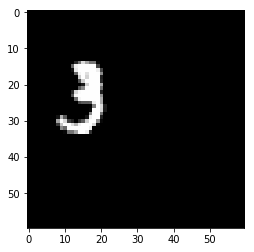

In [12]:
plt.imshow(noised_training_data_set.get_raw_at(10))
print(noised_training_data_set[:2])
print(noised_test_data_set[:2])

[Epoch 0] Training loss: 1601.1780796051025
[Epoch 0] Accuracy: 12724/60000 (21.21%)
[Epoch 1] Training loss: 1440.7456367015839
[Epoch 1] Accuracy: 14024/60000 (23.37%)
[Epoch 2] Training loss: 1424.4359687566757
[Epoch 2] Accuracy: 15237/60000 (25.39%)
[Epoch 3] Training loss: 1421.7116265296936
[Epoch 3] Accuracy: 12451/60000 (20.75%)
[Epoch 4] Training loss: 1380.8478231430054
[Epoch 4] Accuracy: 15244/60000 (25.41%)


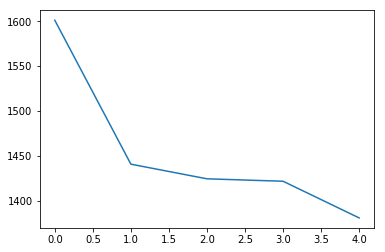

In [14]:
linear_model_2 = LinearClassifier(width=60, height=60)
train(linear_model_2, noised_training_data_set, noised_test_data_set, epoch_count=5)

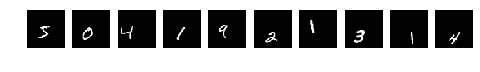

[9, 9, 7, 9, 7, 2, 9, 2, 1, 2]


In [16]:
noised_training_data_set.transform = lambda x: x
predict(linear_model_2, noised_training_data_set, range(10))
noised_training_data_set.transform = pipeline

[Epoch 0] Training loss: 1395.2910606861115
[Epoch 0] Accuracy: 6742/60000 (11.24%)
[Epoch 1] Training loss: 1380.7844240665436
[Epoch 1] Accuracy: 6742/60000 (11.24%)
[Epoch 2] Training loss: 1380.7701089382172
[Epoch 2] Accuracy: 6742/60000 (11.24%)
[Epoch 3] Training loss: 1380.763956785202
[Epoch 3] Accuracy: 6742/60000 (11.24%)
[Epoch 4] Training loss: 1380.7689921855927
[Epoch 4] Accuracy: 6742/60000 (11.24%)


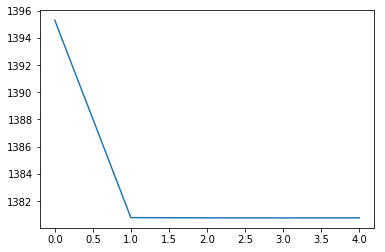

In [17]:
two_layer_model_2 = TwoLayerClassifier(width=60, height=60)
train(two_layer_model_2, noised_training_data_set, noised_test_data_set, epoch_count=5)

[Epoch 0] Training loss: 935.8680188059807
[Epoch 0] Accuracy: 36601/60000 (61.00%)
[Epoch 1] Training loss: 612.1956943869591
[Epoch 1] Accuracy: 43147/60000 (71.91%)
[Epoch 2] Training loss: 526.4285020828247
[Epoch 2] Accuracy: 43661/60000 (72.77%)
[Epoch 3] Training loss: 486.2870938181877
[Epoch 3] Accuracy: 46222/60000 (77.04%)
[Epoch 4] Training loss: 452.7543598115444
[Epoch 4] Accuracy: 46726/60000 (77.88%)


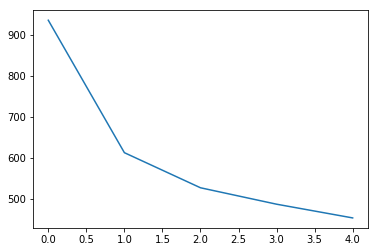

In [20]:
convolutional_model_2 = ConvolutionalClassifier(width=60, height=60)
train(convolutional_model_2, noised_training_data_set, noised_test_data_set, epoch_count=5)

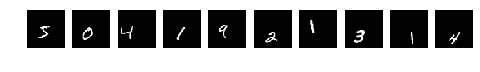

[3, 0, 4, 1, 6, 2, 1, 3, 1, 4]


In [21]:
noised_training_data_set.transform = lambda x: x
predict(convolutional_model_2, noised_training_data_set, range(10))
noised_training_data_set.transform = pipeline

In [95]:
"""
NOW for the really fun part: trying to generate numbers using a GAN
"""

import copy

class NumberGenerator(nn.Module):
    def __init__(self, seed_size, width=28, height=28):
        super().__init__()
        self.seed_size = seed_size
        self.width = width
        self.height = height
        self.fc = nn.Linear(seed_size, self.width * self.height)
    
    def forward(self, seed):
        batch_size, seed_size = seed.shape
        xs = self.fc(seed)
        return xs.reshape((batch_size, 1, self.width, self.height))

class NumberDiscriminator(nn.Module):
    def __init__(self, width=28, height=28):
        super().__init__()
        self.conv = nn.Sequential(
                    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=1, padding=0),
                    nn.MaxPool2d(kernel_size=2),
                    nn.ReLU())
        self.fc = nn.Linear(self.convolution_output_length(width, height), 1)
        self.sigmoid = nn.Sigmoid()
    
    def convolution_output_shape(self, width, height):
        xs = self.conv(torch.zeros(1, 1, width, height))
        return xs.shape
    
    def convolution_output_length(self, width, height):
        length = 1
        for d in self.convolution_output_shape(width, height):
            length *= d
        return length
    
    def forward(self, xs, with_sigmoid=True):
        batch_size, channels, width, height = xs.shape
        xs = self.conv(xs)
        xs = xs.reshape((batch_size, -1))
        xs = self.fc(xs)
        if with_sigmoid:
            xs = self.sigmoid(xs)
        else:
            xs = xs.squeeze(dim=-1)
        return xs
    
    '''
    def __init__(self, width=28, height=28):
        super().__init__()
        self.fc = nn.Linear(width * height, 1) # One entry for fakes
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, xs, with_sigmoid=True):
        batch_size, channels, width, height = xs.shape
        xs = xs.reshape((batch_size, -1))
        xs = self.fc(xs)
        if with_sigmoid:
            xs = self.sigmoid(xs)
        else:
            xs = xs.squeeze(dim=-1)
        return xs
    '''

'''
generator = NumberGenerator()
print(generator(torch.zeros(3, 1)))
discriminator = NumberDiscriminator()
print(discriminator(torch.zeros(3, 1, 28, 28), with_sigmoid=False))
print(discriminator(torch.zeros(3, 1, 28, 28), with_sigmoid=True))
'''
  
def train_gan(generator, discriminator, real_data_set, epoch_count):    
    dis_criterion = nn.BCEWithLogitsLoss()
    gen_optimizer = optim.Adam(params=generator.parameters(), lr=1e-3)
    dis_optimizer = optim.Adam(params=discriminator.parameters(), lr=1e-3)
    
    for epoch in range(epoch_count):
        
        # Generating some random inputs in addition to the normal inputs
        
        xs, ys = [], []
        seeds = torch.randn(len(real_data_set), 1)
        generated = generator(seeds)
        for i in range(len(real_data_set)):
            image, target = real_data_set[i]
            xs.append(torch.clone(image))
            ys.append(1)
            xs.append(generated[i].detach())
            ys.append(0)
        
        # Packaging these inputs into a data set
        
        xs = torch.stack(xs)
        ys = torch.tensor(ys, dtype=torch.float32, requires_grad=False)
        full_data_set = TensorDataset(xs, ys)
        data_loader = DataLoader(full_data_set, batch_size=100, shuffle=True)
        
        # Training the discriminator
        
        dis_cumulative_loss = 0.
        generator.eval()
        discriminator.train()
        
        for inputs, target in data_loader:
            dis_optimizer.zero_grad()
            dis_outputs = discriminator(inputs, with_sigmoid=False)
            dis_loss = dis_criterion(dis_outputs, target)
            dis_loss.backward()
            dis_optimizer.step()
            dis_cumulative_loss += dis_loss.item()
        
        print("Discriminator loss:", dis_cumulative_loss)
        
        # Training the generator
        
        '''
        gen_cumulative_loss = 0.
        generator.train()
        discriminator.train()
        
        for inputs, target in data_loader:
            fake_target = torch.ones(target.shape)
            fake_seed = torch.randn((len(target), generator.seed_size))
            gen_optimizer.zero_grad()
            dis_optimizer.zero_grad()
            generated = generator(fake_seed)
            dis_outputs = discriminator(generated, with_sigmoid=False)
            dis_loss = dis_criterion(dis_outputs, fake_target)
            dis_loss.backward()
            gen_optimizer.step()
            gen_cumulative_loss += dis_loss.item()
        
        print("Generator loss:", gen_cumulative_loss)
        '''
        
generator = NumberGenerator(seed_size=1)
discriminator = NumberDiscriminator()
training_data_set.transform = pipeline
train_gan(generator, discriminator, training_data_set, epoch_count=10)
print('Done')

# TODO - the discriminator must be able to detect which class the object is IN + say whether it is fake or not.
# TODO - start with only the generation of number 5?
    
# TODO - try to generate a sample image (just to check the size)

# TODO - training routine
# https://github.com/QuentinDuval/PythonExperiments/blob/master/Learning/FunctionGAN.py

Discriminator loss: 4.1055791809849325
Discriminator loss: 0.01968304310366875
Discriminator loss: 0.006130914569780543
Discriminator loss: 0.0025415046510488537
Discriminator loss: 0.0011943508552292315
Discriminator loss: 0.0005866512922239053
Discriminator loss: 0.0002982520676866329
Discriminator loss: 0.0001534292517746394
Discriminator loss: 8.104550163068325e-05
Discriminator loss: 4.10778890715946e-05
Done


(28, 28)


AttributeError: 'NumberDiscriminator' object has no attribute 'softmax'

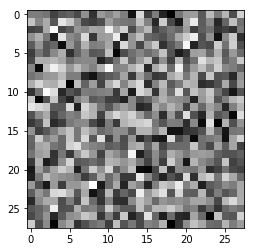

In [94]:
def generate_sample(generator):
    image = generator(torch.randn(1, 1)).squeeze(dim=0).squeeze(dim=0).detach().numpy()
    print(image.shape)

    max_val = image.max()
    min_val = image.min()
    image = (image - min_val) / (max_val - min_val)
    
    image = np.uint8(image * 255)
    image = Image.fromarray(image, 'L')
    plt.imshow(image)

empty_generator = NumberGenerator(seed_size=1)
generate_sample(empty_generator)

print("Real image:", discriminator(training_data_set[0][0].clone().unsqueeze(dim=0)))
print("Fake image:", discriminator(empty_generator(torch.randn(1, 1))))